https://www.cienciadedatos.net/documentos/py08_random_forest_python.html

https://github.com/an-rivas/ENDIREH-data-analysis/blob/preprocesamiento4Cat/OE1_Exploracion/Baseline/Baseline.ipynb

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=forest#sklearn.ensemble.RandomForestClassifier

In [1]:
import pandas as pd
from funciones import CargarPandasDatasetCategoricos, BorrarColumnas, InsertarColumnaNueva

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
from sklearn import tree #La versión que tengo es 0.24.1 y está disponible apartir de la 0.21
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Cargar datos

In [3]:
endireh = CargarPandasDatasetCategoricos('datasets/endirehCat.csv')

In [39]:
endireh.shape

(6161, 70)

### Random forest no usan datos categóricos (object type), para ello obtengo One Hot Encoding con la instruccion pd.get_dummies de pandas para las columnas categóricas

In [4]:
endireh_cat = endireh.drop(columns = ["P9_8", "P1_2", "P1_2_A", "P9_3"])
endireh_cat = pd.get_dummies(endireh_cat)

endireh_num = pd.read_csv('datasets/endirehCat.csv', usecols=["P1_2", "P1_2_A", "P9_3"])
endireh_ohe = pd.concat([endireh_cat, endireh_num], axis=1)

y = pd.read_csv('datasets/endirehCat.csv', usecols=["P9_8"])

## Encontrar los mejores parámetros con _Grid Search_

Declaramos los parametros

In [33]:
param_grid = ParameterGrid(
                    {
                     'n_estimators'      : range(160,165),
                     'criterion'         : ['gini', 'entropy'],
                      'min_samples_split' : range(330, 341),
                      'min_samples_leaf'  : range(90, 101),
                      'random_state'      : [42, 666, 5],
                    }
                )

len(param_grid)

3630

Creamos el diccionario que guadará los resultados

In [34]:
resultados = {'params': [], 'oob_accuracy': []}
importances = []
bestSoFar = [0,0] ## oob score and model

### Loop para ajustar un modelo con cada combinación de hiperparámetros

In [35]:
%%time
print(f'Creando modelos para {len(param_grid)} combinaciones de parámetros.\n')

for i,params in enumerate(param_grid):
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                ** params
             )
    
    modelo.fit(endireh_ohe, y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    
    if(modelo.oob_score_ > bestSoFar[0]):
        bestSoFar[0] = modelo.oob_score_
        bestSoFar[1] = modelo
    
    importances.append(modelo.feature_importances_)
    
    if i%150 == 0 or i==len(param_grid):
        print(f"Modelo {i}: {params} \u2713")

print('\n')

Creando modelos para 3630 combinaciones de parámetros.

Modelo 0: {'criterion': 'gini', 'min_samples_leaf': 90, 'min_samples_split': 330, 'n_estimators': 160, 'random_state': 42} ✓
Modelo 150: {'criterion': 'gini', 'min_samples_leaf': 90, 'min_samples_split': 340, 'n_estimators': 160, 'random_state': 42} ✓
Modelo 300: {'criterion': 'gini', 'min_samples_leaf': 91, 'min_samples_split': 339, 'n_estimators': 160, 'random_state': 42} ✓
Modelo 450: {'criterion': 'gini', 'min_samples_leaf': 92, 'min_samples_split': 338, 'n_estimators': 160, 'random_state': 42} ✓
Modelo 600: {'criterion': 'gini', 'min_samples_leaf': 93, 'min_samples_split': 337, 'n_estimators': 160, 'random_state': 42} ✓
Modelo 750: {'criterion': 'gini', 'min_samples_leaf': 94, 'min_samples_split': 336, 'n_estimators': 160, 'random_state': 42} ✓
Modelo 900: {'criterion': 'gini', 'min_samples_leaf': 95, 'min_samples_split': 335, 'n_estimators': 160, 'random_state': 42} ✓
Modelo 1050: {'criterion': 'gini', 'min_samples_leaf': 96

## Visualizamos resultados

### 17 octubre 3630 combinaciones

    param_grid = ParameterGrid(
                    {
                     'n_estimators'      : range(160,165),
                     'criterion'         : ['gini', 'entropy'],
                      'min_samples_split' : range(330, 341),
                      'min_samples_leaf'  : range(90, 101),
                      'random_state'      : [42, 666, 5],
                    }
                )
            
Puesto a las 15:37 hrs. Basados en el anterior, debería tardar anterior 19~20 hrs. Duró 8 hrs

In [37]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,oob_accuracy,criterion,min_samples_leaf,min_samples_split,n_estimators,random_state
0,0.523129,gini,90,330,160,42
2438,0.523129,entropy,93,338,162,5
2412,0.523129,entropy,93,336,164,42
2413,0.523129,entropy,93,336,164,666
2414,0.523129,entropy,93,336,164,5
2415,0.523129,entropy,93,337,160,42
2416,0.523129,entropy,93,337,160,666
2417,0.523129,entropy,93,337,160,5
2418,0.523129,entropy,93,337,161,42
2419,0.523129,entropy,93,337,161,666


### Feature importance [a](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

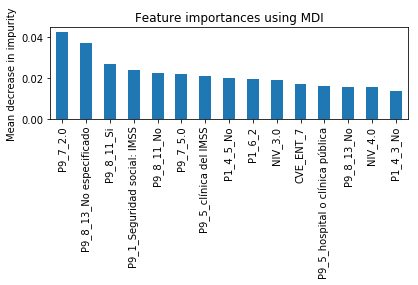

In [38]:
forest_importances = pd.Series(importances[0], index=endireh_ohe.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances[:15].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 16 octubre 2520 combinaciones

    param_grid = ParameterGrid(
                {
                 'n_estimators'      : range(160, 190, 5),
                 'criterion'         : ['gini', 'entropy'],
                  'min_samples_split' : range(326, 351, 4),
                  'min_samples_leaf'  : range(91, 120, 3),
                  'random_state'      : [42, 666, 5],
                }
            )
            
Puesto a las 23:51 hrs. Basados en el anterior, debería tardar anterior 13~14 hrs. Terminar 2pm del 17. Duró 13hrs 32 min 56s

In [18]:
#resultados = pd.DataFrame(resultados)
#resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
#resultados = resultados.sort_values('oob_accuracy', ascending=False)
#resultados = resultados.drop(columns = 'params')
resultados.head(5)

,oob_accuracy,criterion,min_samples_leaf,min_samples_split,n_estimators,random_state
0,0.523129,gini,91,326,160,42
1683,0.523129,entropy,100,334,175,42
1676,0.523129,entropy,100,334,160,5
1677,0.523129,entropy,100,334,165,42
1678,0.523129,entropy,100,334,165,666


### Feature importance [a](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

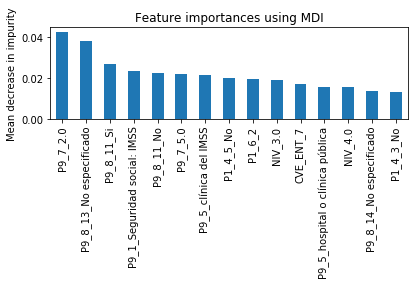

In [16]:
forest_importances = pd.Series(importances[0], index=endireh_ohe.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances[:15].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 16 de noviembre 900 combinaciones

4 hrs 30 min 8 seg

    param_grid = ParameterGrid(
                {
                 'n_estimators'      : range(140, 190, 10),
                 'criterion'         : ['gini', 'entropy'],
                  'min_samples_split' : range(330, 351, 5),
                  'min_samples_leaf'  : range(100, 130, 5),
                  'random_state'      : [42, 666, 5],
                }
            )

In [8]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,oob_accuracy,criterion,min_samples_leaf,min_samples_split,n_estimators,random_state
0,0.523129,gini,100,330,140,42
563,0.523129,entropy,105,340,160,5
593,0.523129,entropy,105,350,160,5
594,0.523129,entropy,105,350,170,42
595,0.523129,entropy,105,350,170,666
596,0.523129,entropy,105,350,170,5
597,0.523129,entropy,105,350,180,42
598,0.523129,entropy,105,350,180,666
599,0.523129,entropy,105,350,180,5
600,0.523129,entropy,110,330,140,42


In [9]:
resultados.shape

(900, 6)

In [10]:
importances[0][:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Feature importance [a](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

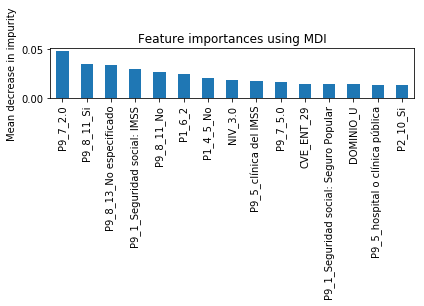

In [11]:
forest_importances = pd.Series(importances[0], index=endireh_ohe.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances[:15].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Tree visualization

This is only one of the estimators that have been fit by the classifier, and does not represent the criteria followed by the classifier, which is an ensemble of multiple trees.

Will show an text printed version of the tree (https://www.py4u.net/discuss/261719).

In [21]:
fn = endireh_ohe.columns
cn = ['Abuso y violencia', 'Atencion no autorizada', 'Ambos']


r = export_text(bestSoFar[1].estimators_[3], feature_names=fn)
print(r)

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Will show the tree in the notebook and if wanted can save the image.

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

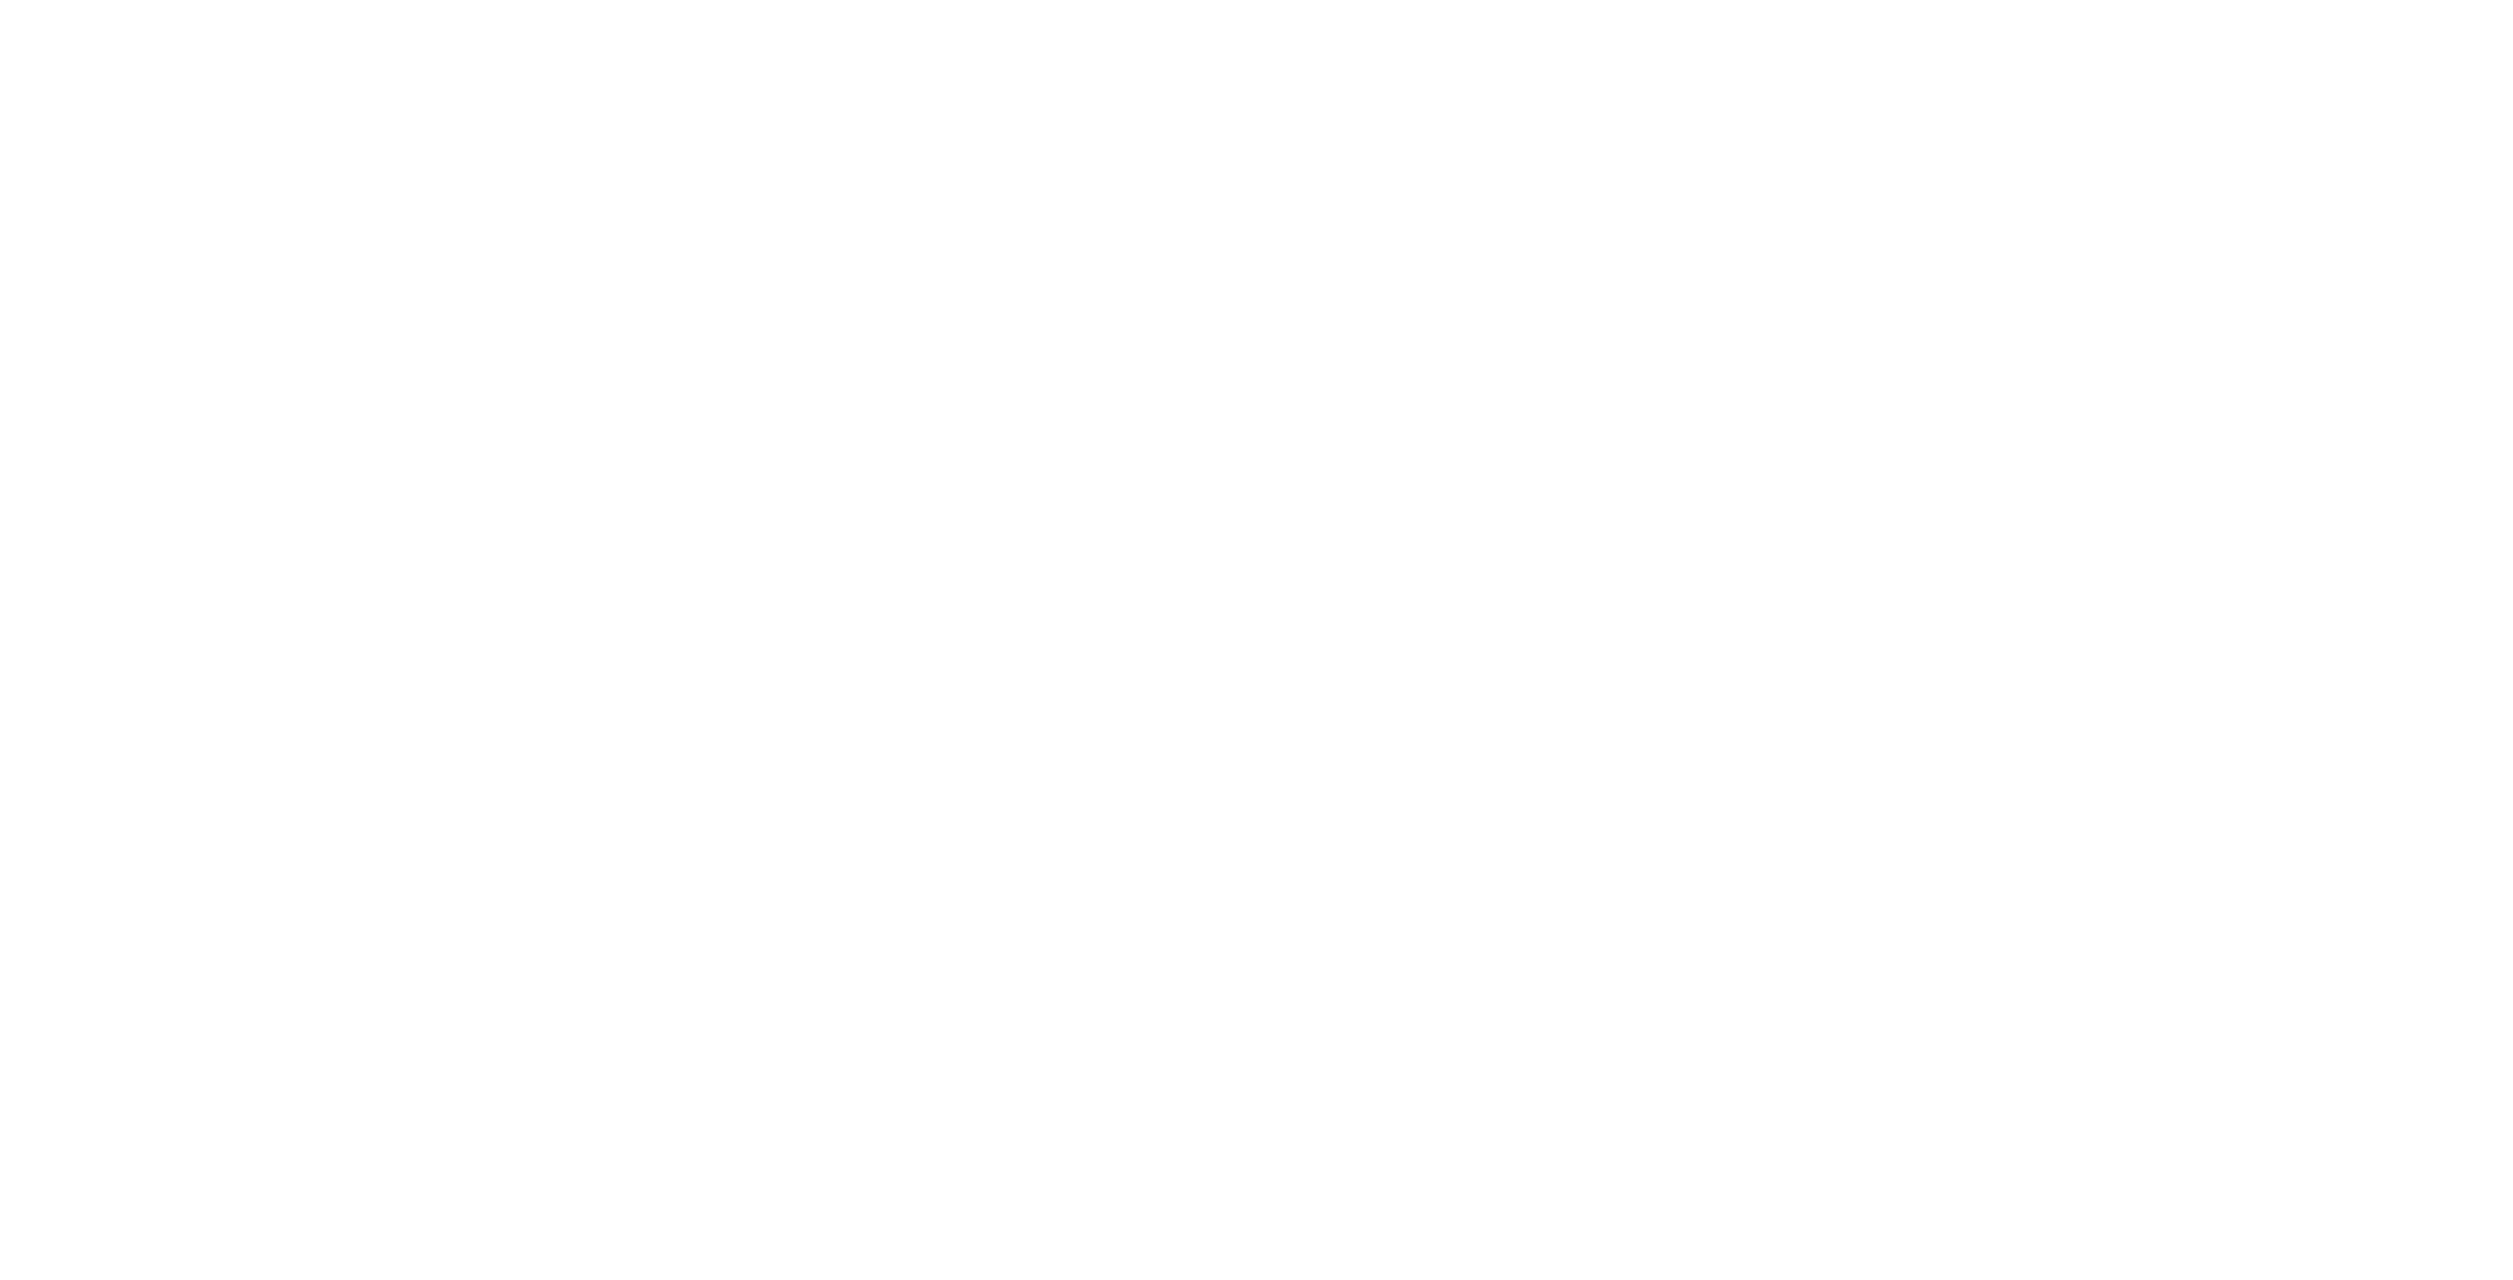

In [22]:
fn = endireh_ohe.columns
cn = ['Abuso y violencia', 'Atencion no autorizada', 'Ambos']
fig, axes = plt.subplots(nrows = 1,
                         ncols = 1, 
                         figsize = (10, 5),
                         dpi=300)

tree.plot_tree(bestSoFar[1],
               feature_names = fn, 
               class_names=cn,
               filled = True);
#fig.savefig('imagename.png')

Makes a dot file, that is process to make a image and then upload it and show it in the notebook.

In [23]:
fn = endireh_ohe.columns
cn = ['Abuso y violencia', 'Atencion no autorizada', 'Ambos']

# Export as dot file
export_graphviz(bestSoFar[1], 
                out_file='tree_prueba.dot', 
                feature_names = fn,
                class_names = cn,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

In [74]:
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree_prueba.dot', '-o', 'tree_prueba.png', '-Gdpi=600'])

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

In [76]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_prueba.png')

FileNotFoundError: [Errno 2] No such file or directory: 'tree_prueba.png'